<a href="https://colab.research.google.com/github/mikel-brostrom/flight-passengers-prediction-LSTM/blob/master/flight_passengers_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This dataset provides monthly totals of a US airline passengers (in 1000s) from 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.

(https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb)

In [137]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2020-05-31 20:02:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.2’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2020-05-31 20:02:33 (37.1 MB/s) - ‘airline-passengers.csv.2’ saved [2180/2180]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# The data

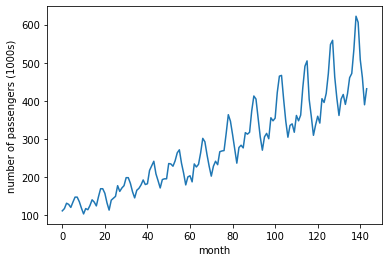

In [140]:
training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

# Generate test and train data

In [141]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.30)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(training_data.shape)
print(dataX.shape)
print(dataY.shape)

(144, 1)
torch.Size([139, 4, 1])
torch.Size([139, 1])


# The network

In [0]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# Training

In [143]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 0.37345
Epoch: 100, loss: 0.00293
Epoch: 200, loss: 0.00241
Epoch: 300, loss: 0.00185
Epoch: 400, loss: 0.00140
Epoch: 500, loss: 0.00117
Epoch: 600, loss: 0.00110
Epoch: 700, loss: 0.00108
Epoch: 800, loss: 0.00106
Epoch: 900, loss: 0.00104
Epoch: 1000, loss: 0.00102
Epoch: 1100, loss: 0.00100
Epoch: 1200, loss: 0.00098
Epoch: 1300, loss: 0.00096
Epoch: 1400, loss: 0.00095
Epoch: 1500, loss: 0.00093
Epoch: 1600, loss: 0.00091
Epoch: 1700, loss: 0.00090
Epoch: 1800, loss: 0.00089
Epoch: 1900, loss: 0.00088


# Evaluation

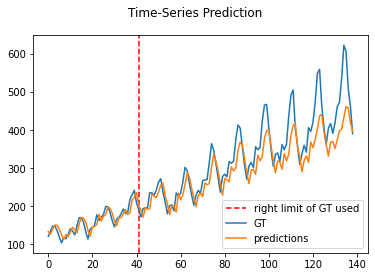

In [144]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX)

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')

plt.plot(dataY_plot, label='GT')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()